In [171]:
import xgboost as xgb
import pandas as pd
import numpy as np
pd.set_option('display.max_columns',None)

from src.features import build_features as f
from importlib import reload
reload(f)

vladdy = 665489
soto = 665742
schneider = 676914
biggio = 624415
showtime = 660271
batter = showtime

X_train, y_train, X_test, y_test, encoders = f.get_pitch_outcome_dataset_xgb(batter, split=True)

In [27]:
from sklearn.model_selection import GridSearchCV
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.5, 1.0],
    'colsample_bytree': [0.5, 1.0]
}

clf = xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss')

# Initialize GridSearchCV with more folds
grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, cv=3, verbose=1)

# Fit GridSearchCV with early stopping parameters
grid_search.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Print the best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.5}
Best Score: 0.5972116873249035


In [185]:
grid_search.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 100,
 'subsample': 0.5}

In [186]:
params = {'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 100,
 'subsample': 0.5}
clf = xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', **params)
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

Accuracy: 0.707723279648609
Accuracy: 0.6106995884773663


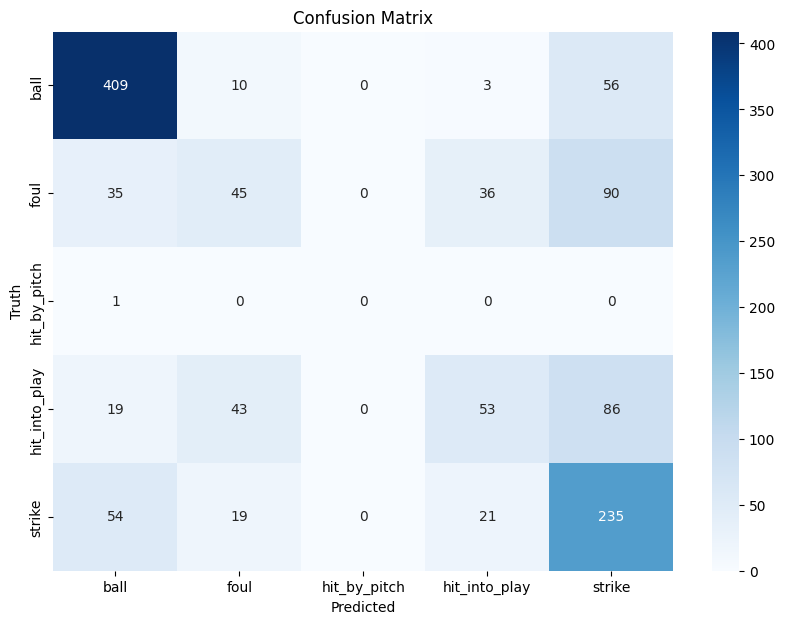

In [187]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Accuracy:", accuracy_score(y_train, clf.predict(X_train)))
print("Accuracy:", accuracy_score(y_test, clf.predict(X_test)))

target_col = 'pitch_outcome'

y_test_lab = encoders[target_col].inverse_transform(y_test[target_col])
y_pred_lab = encoders[target_col].inverse_transform(clf.predict(X_test))

unique_labels = np.unique(np.concatenate((y_test_lab, y_pred_lab)))
cm = confusion_matrix(y_test_lab, y_pred_lab)

import matplotlib.pyplot as plt
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.title("Confusion Matrix")
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

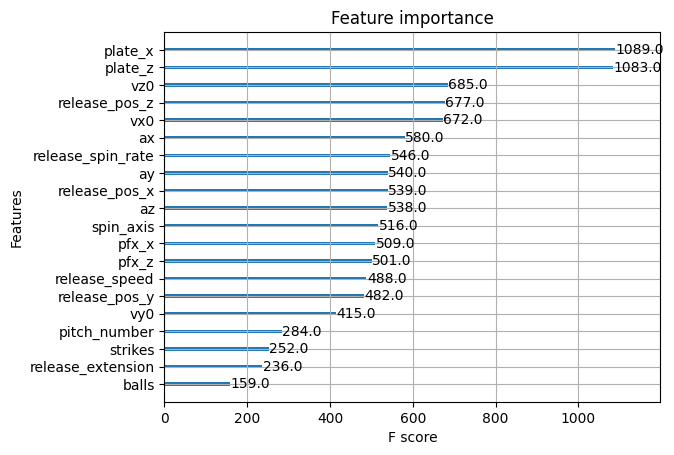

In [176]:
xgb.plot_importance(clf)

In [177]:
from copy import deepcopy
X = deepcopy(X_test)
X['pitch_outcome'] = encoders[target_col].inverse_transform(y_test)

outcomes = []
for row in clf.predict_proba(X_test):
    choice = np.random.choice(a=len(row), p=row)
    outcomes.append(choice)

X['pitch_outcome_pred'] = encoders[target_col].inverse_transform(outcomes)

/home/reece/miniconda3/envs/mlb/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [192]:
dict(X_train.iloc[0])

{'pitch_number': 1.0,
 'strikes': 0.0,
 'balls': 0.0,
 'release_speed': 91.5,
 'release_spin_rate': 2541.0,
 'release_extension': 6.3,
 'release_pos_x': -1.1,
 'release_pos_y': 54.2,
 'release_pos_z': 5.71,
 'spin_axis': 201.0,
 'pfx_x': -0.38,
 'pfx_z': 1.0,
 'vx0': 5.52946075120911,
 'vy0': -133.034107193298,
 'vz0': -5.81172219449376,
 'ax': -5.79249929698345,
 'ay': 31.1262248305161,
 'az': -19.2977353984413,
 'plate_x': 0.77,
 'plate_z': 1.91}

In [198]:
encoders[target_col].inverse_transform([y_train.iloc[0]])


/home/reece/miniconda3/envs/mlb/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(['hit_into_play'], dtype=object)

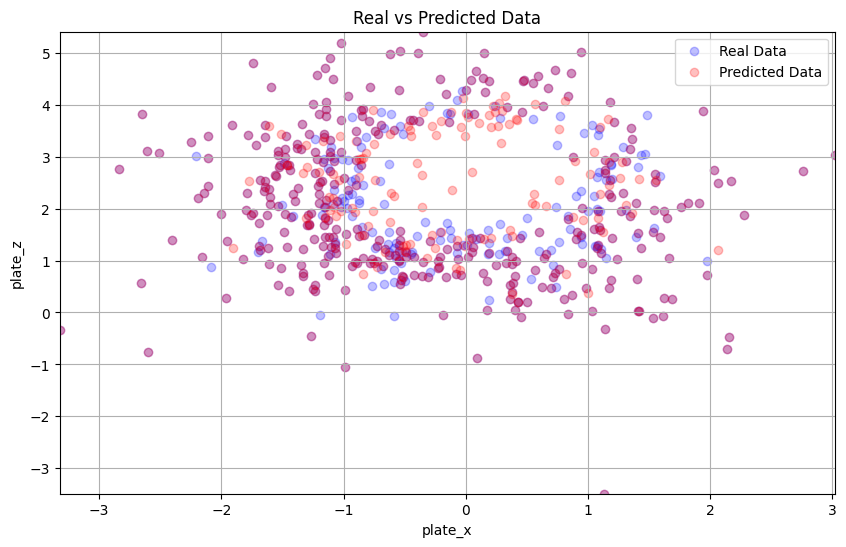

In [183]:
def analyze_predictions(df, x_col='plate_x', y_col='plate_z', class_name='strike', target_col='pitch_outcome'):
    real_df = df[df[target_col]==class_name][[x_col, y_col]]
    pred_df = df[df[(target_col + '_pred')]==class_name][[x_col, y_col]]

    #print(real_df)
    #print(pred_df)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(real_df[x_col], real_df[y_col], color='blue', label='Real Data', alpha=0.25)
    plt.scatter(pred_df[x_col], pred_df[y_col], color='red', label='Predicted Data', alpha=0.25)
    
    # Adding labels and title
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title('Real vs Predicted Data')
    
    # Adding legend
    plt.legend()
    
    # Ensuring the x and y scales are the same
    plt.xlim(min(real_df[x_col].min(), pred_df[x_col].min()), max(real_df[x_col].max(), pred_df[x_col].max()))
    plt.ylim(min(real_df[y_col].min(), pred_df[y_col].min()), max(real_df[y_col].max(), pred_df[y_col].max()))
    
    # Show plot
    plt.grid(True)
    plt.show()

analyze_predictions(X, class_name='ball')

In [118]:
strikes = X[X['pitch_outcome']=='strike'][['plate_x', 'plate_z']]

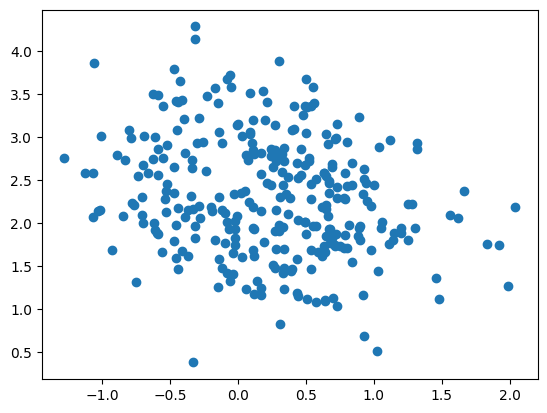

In [122]:
import matplotlib.pyplot as plt

plt.scatter(strikes['plate_x'], strikes['plate_z'])

In [105]:
def compute_xgboost_loglik(y_pred_proba, y_test, target_col):
    loglik = 0
    for idx, target in enumerate(y_test[target_col]):
        loglik += np.log(y_pred_proba[idx, target])
    return loglik

def compute_cat_loglik(X_train, y_train, y_test, target_col):

    df = pd.concat([X_train, y_train], axis=1)
    
    pitch_cat_prob = (df[target_col].value_counts() / len(df)) 
    
    loglik = 0
    for target in y_test[target_col]:
        loglik += np.log(pitch_cat_prob.loc[target])
    return loglik

target_col = 'pitch_outcome'
xgb_loglik = compute_xgboost_loglik(clf.predict_proba(X_test), y_test, target_col)
cat_loglik = compute_cat_loglik(X_train, y_train, y_test, target_col)
print(f'XGB: {xgb_loglik:.2f}, CAT: {cat_loglik:.2f}')

XGB: -1019.82, CAT: -1546.07


In [106]:
pd.DataFrame(encoders[target_col].inverse_transform(y_test)).value_counts()
#y_test.value_counts()

/home/reece/miniconda3/envs/mlb/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0            
ball             471
strike           297
hit_into_play    200
foul             196
hit_by_pitch       1
Name: count, dtype: int64

In [107]:
#pd.DataFrame(encoders[target_col].inverse_transform(clf.predict(X_test))).value_counts()
dfs = []

for i in range(1000):
    outcomes = []
    for row in clf.predict_proba(X_test):
        choice = np.random.choice(a=len(row), p=row)
        outcomes.append(choice)
        
    dfs.append(pd.DataFrame(encoders[target_col].inverse_transform(outcomes)).value_counts().reset_index())

In [108]:
#df_list = [series.to_frame(name='count').reset_index().rename(columns={'index': 'category'}) for series in data_list]

# Concatenate all DataFrames
concatenated_df = pd.concat(dfs)

# Group by category and calculate the mean
average_counts = concatenated_df.groupby(0)['count'].mean()

#print(average_counts)
average_counts

0
ball             449.655000
foul             190.706000
hit_by_pitch       1.463308
hit_into_play    239.294000
strike           284.009000
Name: count, dtype: float64

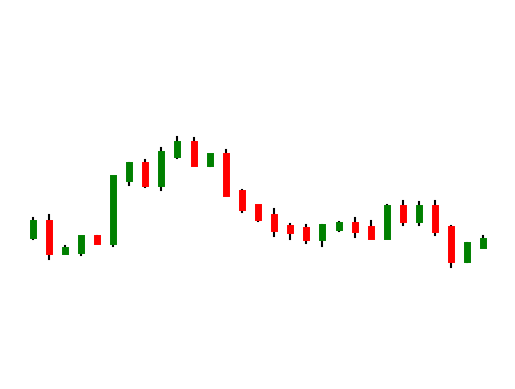

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

pip_size = 0.0001  # assuming EUR/USD or similar currency pair
upper_limit = current_price + 100 * pip_size
lower_limit = current_price - 100 * pip_size

num_candles = 30
start_price = 1.2000

# Generate random price changes
price_changes = np.random.randn(num_candles) * 0.001  # small random changes
prices = start_price + np.cumsum(price_changes)

# Create OHLC data
open_prices = prices[:-1]
close_prices = prices[1:]
high_prices = np.maximum(open_prices, close_prices) + np.random.rand(num_candles - 1) * 0.0005
low_prices = np.minimum(open_prices, close_prices) - np.random.rand(num_candles - 1) * 0.0005

# Create DataFrame
data = {
    'Timestamp': list(range(num_candles-1)),
    'Open': open_prices,
    'High': high_prices,
    'Low': low_prices,
    'Close': close_prices
}
df = pd.DataFrame(data)

# Calculate the current price (e.g., the latest close price)
current_price = df['Close'].iloc[-1]

# Plot the candlestick chart
fig, ax = plt.subplots()

# Convert timestamp to matplotlib date format
#df['Timestamp'] = pd.to_datetime(filtered_df['Timestamp'])
#df['Timestamp'] = df['Timestamp'].apply(mdates.date2num)

# Define the candlestick chart function
def plot_candlestick(ax, df):
    for index, row in df.iterrows():
        color = 'green' if row['Close'] >= row['Open'] else 'red'
        ax.plot([row['Timestamp'], row['Timestamp']], [row['Low'], row['High']], color='black')
        ax.plot([row['Timestamp'], row['Timestamp']], [row['Open'], row['Close']], color=color, linewidth=5)

# Apply the candlestick plotting function
plot_candlestick(ax, df)

# Set the limits and remove axis labels
ax.set_ylim([lower_limit, upper_limit])
#ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Hide x-axis and y-axis labels
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

# Hide gridlines
ax.grid(False)

# Hide the frame
ax.set_frame_on(False)

plt.show()


In [22]:
df.iloc[-1]
df

,Timestamp,Open,High,Low,Close
0,0,1.201015,1.201385,1.200308,1.200597
1,1,1.200597,1.200690,1.198997,1.199105
2,2,1.199105,1.200592,1.198674,1.200332
3,3,1.200332,1.201333,1.199976,1.201011
4,4,1.201011,1.202841,1.200740,1.202402
5,5,1.202402,1.202472,1.201603,1.202099
6,6,1.202099,1.203775,1.201809,1.203549
7,7,1.203549,1.205510,1.203059,1.205083
8,8,1.205083,1.206479,1.204690,1.206191
9,9,1.206191,1.206352,1.205313,1.205813
